# =========================產生模型檔=========================
## 透過先前特徵工程所找到最佳的參數來訓練模型並產生模型檔
## 使用此模型檔便可進行預測硬幣種類
***

## 匯入相關套件

In [1]:
import cv2
import numpy as np
import pandas as pd
from sklearn import svm
import pickle

## 匯入資料集

In [2]:
dataset_dir = '../model/'

df = pd.read_csv(dataset_dir + 'train.csv')
FEATURES = ['R', 'G', 'B', 'His_AVG', 'His_STD']

X = df[FEATURES].values # 此處將 X 轉換為 Numpy 陣列，便不會包含特徵名稱，以避免預測時跳出警告
y = df['Label']

## 根據特徵工程找到最佳的參數訓練模型

In [3]:
# Best params:{'SVC__C': 3, 'SVC__degree': 2, 'SVC__kernel': 'rbf'}
# 訓練模型
svm_model = svm.SVC(C = 3, degree = 2, kernel = 'rbf')
svm_model.fit(X, y)

SVC(C=3, degree=2)

## 匯出模型檔

In [4]:
# 將模型保存到檔案
model_filename = '../model/svm_model.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(svm_model, file)

## 建立特徵提取函式
### 根據先前提取特徵的方式來將接下來要測試的圖片轉成數值

In [5]:
def sobelEdgeDetection(f):
    grad_x = cv2.Sobel(f, cv2.CV_32F, 1, 0, ksize = 3)
    grad_y = cv2.Sobel(f, cv2.CV_32F, 0, 1, ksize = 3)
    magnitude = abs(grad_x) + abs(grad_y)
    g = np.uint8(np.clip(magnitude, 0, 255))

    return g

def calculateColorAvg(channel, center, offset = 5):
    neighbors = [(center[0] + dx, center[1] + dy) for dx in range(-offset, offset+1, offset) for dy in range(-offset, offset+1, offset)]
    values = [channel[y, x] for x, y in neighbors]
    average_value = int(sum(values) / len(values))
    
    return average_value

def calculateFeature(image, center = (22,22)):
    B = calculateColorAvg(image[:, :, 0], center)
    G = calculateColorAvg(image[:, :, 1], center)
    R = calculateColorAvg(image[:, :, 2], center)

    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sobel_image = sobelEdgeDetection(gray_image)
    His_AVG = int(sobel_image[center[0]].mean())
    His_STD = int(sobel_image[center[0]].std())
    
    return R, G, B, His_AVG, His_STD

## 讀取剛剛所匯出的模型檔，並建立預測硬幣類別的函式

In [6]:
# 加載模型檔案
with open(model_filename, 'rb') as file:
    loaded_model = pickle.load(file)
# 預測新的硬幣圖像
def predict_coin(coin_image_path):
    image = cv2.imread(coin_image_path)
    image = cv2.resize(image,(45,45))
    feature = np.array(calculateFeature(image)).reshape(1, -1)
    predicted_label = loaded_model.predict(feature)
   
    return predicted_label

## 預測硬幣類別
### 其圖片檔名就是該類別

In [7]:
data_dir = '../data/coinData_test/'
print('圖片類別是11，預測為：',predict_coin(data_dir + '11.png'))
print('圖片類別是12，預測為：',predict_coin(data_dir + '12.png'))
print('圖片類別是51，預測為：',predict_coin(data_dir + '51.png'))
print('圖片類別是52，預測為：',predict_coin(data_dir + '52.png'))
print('圖片類別是101，預測為：',predict_coin(data_dir + '101.png'))
print('圖片類別是102，預測為：',predict_coin(data_dir + '102.png'))
print('圖片類別是103，預測為：',predict_coin(data_dir + '103.png'))
print('圖片類別是501，預測為：',predict_coin(data_dir + '501.png'))
print('圖片類別是502，預測為：',predict_coin(data_dir + '502.png'))

圖片類別是11，預測為： [11]
圖片類別是12，預測為： [11]
圖片類別是51，預測為： [101]
圖片類別是52，預測為： [52]
圖片類別是101，預測為： [103]
圖片類別是102，預測為： [102]
圖片類別是103，預測為： [103]
圖片類別是501，預測為： [501]
圖片類別是502，預測為： [502]


# 最終成果
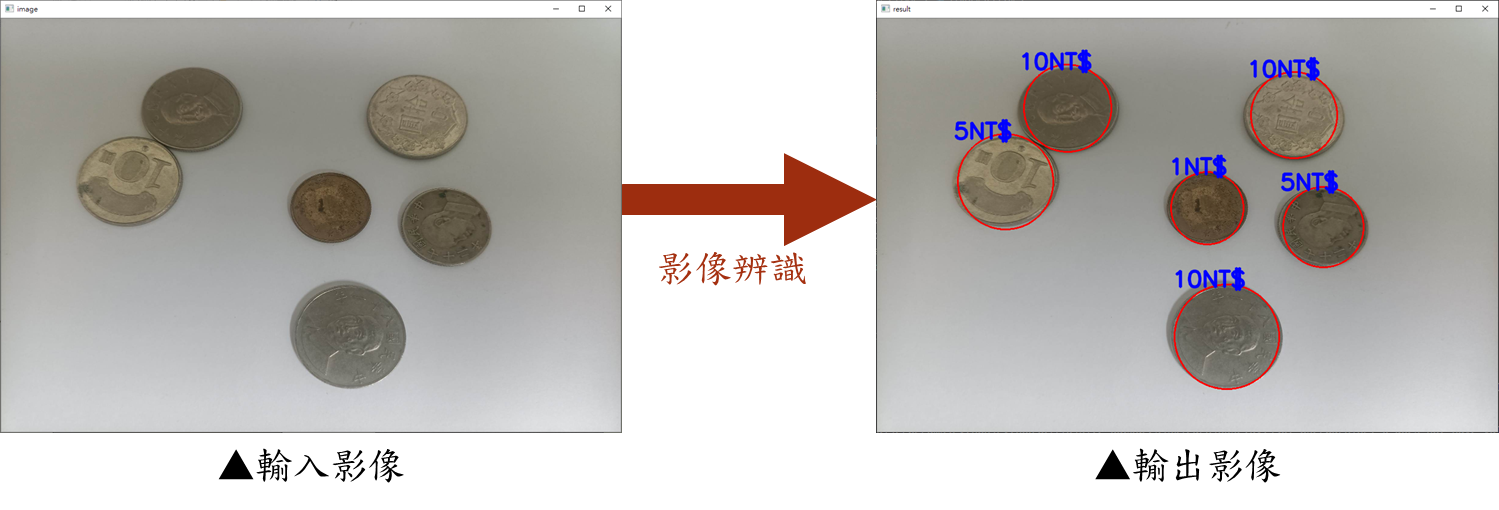
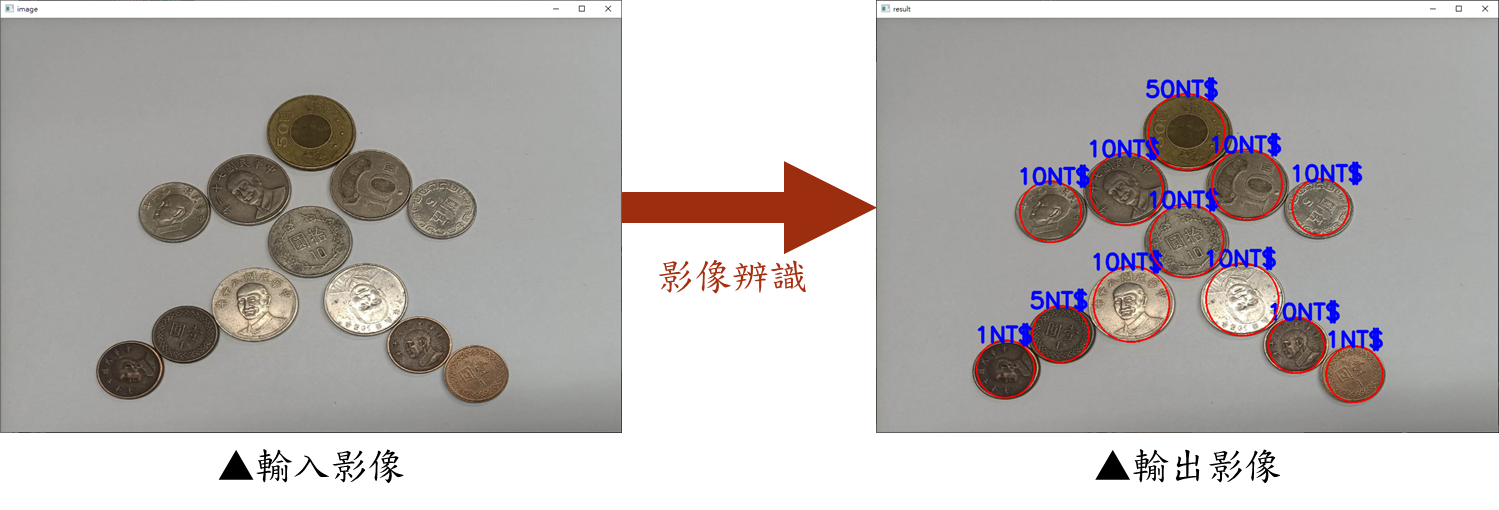